In [1]:
"""IMPORTS
"""

import sys
#sys.path.append("../DBL-Data-Challenge")
from database.connect import getConnection
import pandas as pd
import seaborn as sns
sns.set()
import random
import matplotlib.pyplot as plt
from globals import airlineIDs
import re

"""MODEL IMPORTS
"""
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
#model.save_pretrained(MODEL)

/Users/alicialarsen/anaconda3/envs/ok/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [2]:
text = preprocess(str('I just went on a weekend trip to Hawaii with @Dani531 and it was awesome! https://en.wikipedia.org/wiki/Hawaii'))
print(text)

I just went on a weekend trip to Hawaii with @user and it was awesome! http


In [3]:
try:
    connection1 = getConnection()
except Exception:
    print("✖️ Error while connecting to MySQL engine database.")
    print("ℹ️ Please make sure the environment file `.env` is located at"+
        "the project root directory and contains proper configuration.")
    raise

In [4]:
"""Loads all the relevant data, this takes ~10 min.
"""

# Connects to database
cursor = connection1.cursor()

print("The tweets are being queried")
query="SELECT text, user_id, user_mentions FROM tweets"
cursor.execute(query)

print('The tweets are being fetched')
texts = cursor.fetchall()
number_tweets = cursor.rowcount
print("Total number of rows in table: ", number_tweets)

# Index column is being added
#print("Index is being added")
query= "DROP TABLE tweets_with_index"
cursor.execute(query)

# Create new table will the relevant data
query= "CREATE TABLE tweets_with_index SELECT ROW_NUMBER() OVER() AS row_num, text, user_id, user_mentions FROM tweets"
cursor.execute(query)
print('Index added')

# Generate random list
randomlist = []
for i in range(0, 6000):
    n = random.randint(0, number_tweets-1)
    randomlist.append(n)

# Make list of languages
print("The sentiment is being detected")
sentiment_list = []
user_mention_list = []
for i in randomlist:  
    try:
        # Sentiment detection
        text = preprocess(str(texts[i][0]))
        encoded_input = tokenizer(text, return_tensors='pt')
        output = model(**encoded_input)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)
        ranking = np.argsort(scores)
        ranking = ranking[::-1]
        score_tuple = (scores[ranking[0]], scores[ranking[1]], scores[ranking[2]])
        #print(sum(score_tuple))  
        sentiment_list.append(score_tuple)
        # User mentions
        dicts_str = (texts[i][2])
        tweet_mentions_list = re.findall("'id':\s*(\d*)", dicts_str)
        user_mention_list.append(tweet_mentions_list)
    except Exception:
        sentiment_list.append('NI')
        user_mention_list.append('Null')


#print(sentiment_list)
#print(user_mention_list)

# Add the result to the table (Probably needs some modifications)
"""
print("The tweets are being added to the table")
for i, j in enumerate(lang_list): # i = index, j = language
    query = f"UPDATE tweets_with_index SET lang = '{str(j)}' WHERE row_num = {int(i+1)}"
    cursor.execute(query)
"""

"""
print("A selection is being fetched to show that everything when correctly")
query = "SELECT * FROM tweets_with_index LIMIT 5"
cursor.execute(query)
head = cursor.fetchall()

print("The first 5 rows are being printed:")
for row in head:
    print(row)

"""
cursor.close()
connection1.close()
print('Connection closed!')

The tweets are being queried
The tweets are being fetched
Total number of rows in table:  6094135
Index added
The sentiment is being detected
1.0000000344589353
1.0
0.9999999576248229
0.999999925494194
1.0000000670552254
0.9999999264255166
1.0000001033768058
1.0000000642612576
0.9999999217689037
0.9999999152496457
1.0
1.0
0.999999925494194
0.9999999925494194
0.999999993480742
1.0000000707805157
0.9999999813735485
0.9999999608844519
1.0
1.0000000391155481
0.9999998733401299
1.0000000484287739
0.9999999888241291
1.0000000778818503
0.999999986961484
1.0000000223517418
0.9999999068677425
1.0000000251457095
1.000000037252903
1.0000000447034836
1.0000000232830644
0.9999999860301614
0.9999999329447746
1.0000000186264515
0.9999999580904841
1.0000000246800482
0.9999999729916453
1.0000000037252903
0.9999999776482582
0.9999999948777258
1.0000000316649675
1.0000000093132257
1.000000040512532
0.9999999925494194
0.9999999925494194
1.0000000093132257
1.0000000037252903
1.000000074505806
0.99999997066

In [5]:
sentiment_df = pd.DataFrame(columns=['pos', 'neg', 'neu'])
for i, tuple in enumerate(sentiment_list):
    sentiment_df.loc[i, 'pos'] = tuple[0]
    sentiment_df.loc[i, 'neg'] = tuple[1]
    sentiment_df.loc[i, 'neu'] = tuple[2]

sentiment_df

,pos,neg,neu
0,0.731784,0.259369,0.008847
1,0.743798,0.131007,0.125196
2,0.943951,0.050285,0.005764
3,0.89605,0.056843,0.047107
4,0.787984,0.195462,0.016554
...,...,...,...
5995,0.740565,0.147751,0.111684
5996,0.55368,0.422704,0.023616
5997,0.904396,0.081456,0.014148
5998,0.958064,0.036297,0.005639


In [6]:
mean_senti_df = pd.DataFrame(columns=['pos', 'neu', 'neg'])
mean_senti_df.loc[0, 'pos'] = sentiment_df['pos'].mean()
mean_senti_df.loc[0, 'neu'] = sentiment_df['neu'].mean()
mean_senti_df.loc[0, 'neg'] = sentiment_df['neg'].mean()
mean_senti_df.head()

,pos,neu,neg
0,0.802127,0.026236,0.171637


Text(0, 0.5, 'Percentage of detection (%)')

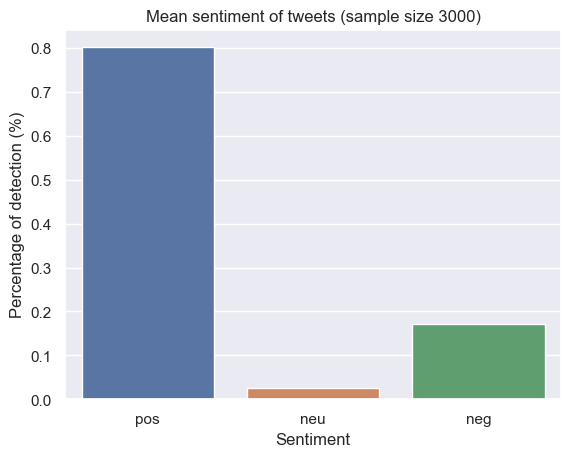

In [7]:
ax = sns.barplot(mean_senti_df)
ax.set_title("Mean sentiment of tweets (sample size 3000)")
ax.set_xlabel('Sentiment')
ax.set_ylabel('Percentage of detection (%)')

### User mentions

In [8]:
# Add user mentions to dataframe (list of user IDs)
sentiment_df['mentions'] = user_mention_list
sentiment_df.head()

,pos,neg,neu,mentions
0,0.731784,0.259369,0.008847,[119177810]
1,0.743798,0.131007,0.125196,[18332190]
2,0.943951,0.050285,0.005764,"[22536055, 15519886]"
3,0.89605,0.056843,0.047107,[253340062]
4,0.787984,0.195462,0.016554,"[18680839, 22536055]"


In [9]:
# Detect the users 
# (what airline is it? Or is it not an airline?)
sentiment_df['user_mentions'] = 'Null'
sentiment_df['airline'] = 'Null'

# For every list of mentions per tweet
for i, mentions in enumerate(sentiment_df['mentions']):

    mentions_list = []
    airline = 'no_airline'
    # check for every mention
    added = False
    for mention in mentions:
        # if the mention is an airline
        added = False
        for key in airlineIDs:
            if int(mention) == int(airlineIDs[key]):
                mentions_list.append(key)
                airline = key
                added = True
                continue
        if added == False:
            mentions_list.append('not_airline')
    if added == False:
        airline = 'no_airline'
        #airlines.append('no_airline')
    sentiment_df['user_mentions'][i] = mentions_list
    sentiment_df['airline'][i] = airline

#lang_df = lang_df.drop(labels=-1, axis=0)
sentiment_df.head()

,pos,neg,neu,mentions,user_mentions,airline
0,0.731784,0.259369,0.008847,[119177810],[not_airline],no_airline
1,0.743798,0.131007,0.125196,[18332190],[BritishAirways],BritishAirways
2,0.943951,0.050285,0.005764,"[22536055, 15519886]","[AmericanAir, not_airline]",no_airline
3,0.89605,0.056843,0.047107,[253340062],[SingaporeAir],SingaporeAir
4,0.787984,0.195462,0.016554,"[18680839, 22536055]","[not_airline, AmericanAir]",AmericanAir


### Sentiment per airline

In [10]:
# Group by airline and sentiment
sentiment_df = sentiment_df.groupby(['airline'])[['pos', 'neg', 'neu']].mean()
sentiment_df.head()

,pos,neg,neu
airline,,,
AirFrance,0.792127,0.187487,0.020386
AmericanAir,0.796134,0.178674,0.025192
BritishAirways,0.795556,0.181250,0.023193
EtihadAirways,0.841252,0.143340,0.015408
KLM,0.805124,0.176976,0.017900


<Axes: xlabel='airline'>

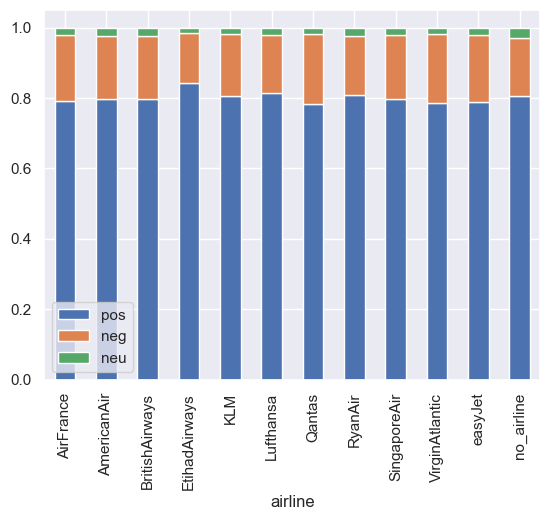

In [11]:
# Plot stacked bar chart: sentiment per airline
sentiment_df.plot(kind='bar', stacked=True, ) 

In [50]:
# Detect sentiment per airline
